__Complete all cells marked with ## TO DO! ## and submit the filled notebook on OLAT__ 

In [1]:
%matplotlib inline

In [2]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


Note: Tasks in these notebooks can be solved without a GPU as well

__Objective of this notebook is to give hands on experience in training a Convolutional Neural Network(CNN) from scratch using Pytorch framework. Further the tasks will also give an insight on how to change the network architecture and hyperparameter settings to achieve better results.__

Fill the code in the notebook where it is explicitly mentioned and solve all tasks to complete the assignment

We divide our task in followind steps:

1- We load the CIFAR-10 dataset and try to look at some properties of the dataset like:
    * size of the images
    * number of images in the dataset
    * number of channels in the image(RGB 3 channel or grayscale single channel image)
    * number of classes in the dataset
    
    
2- We define a network architecture which takes batches of the images in the form of a 4-dimensional tensor and compute the output scores for each class in the dataset

3- We define our loss function for training the network and an optimizer(SGD, Adam, or Adagrad) which defines the strategy to update weights of the network

4- We finally train our network and try to find out the accuracy on validation set, and eventaully improve the network architecture to get better accuracy

---

__Step-1__ : Loading the CIFAR-10 dataset is very easy using ``torchvision`` package, which has readily availabe famous datasets and API to load these datasets into batches known as dataloaders via ``torchvision.Datasets``and ``torch.utils.data.DataLoader'``

In [3]:
import torchvision

In [4]:
####################################################################################################
## TO DO! : Define transform variable                                                             ##
####################################################################################################


# First define a transform to convert RGB images in tensors to tensors and normalize
# them with the channel-wise mean and standard deviation of the 
# CIFAR-10 dataset
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                         (0.2023, 0.1994, 0.2010)),
])

In [5]:
# Use above transform as an argument to load the training and
# the test set for CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
####################################################################################################
## TO DO! : Write code to  print below                                                            ##
## mentioned statistics                                                                           ##
####################################################################################################


# Write code to 
# extract and print the below statistics from above defined Dataset :
# size of the images (height, width and number of channels)
# size of the training images
# size of the test images
# Classes in CIFAR-10 dataset

print("Shape of one data item", trainset.__getitem__(0)[0].shape)
print(len(trainset))
print(len(testset))
print(trainset.classes)

Shape of one data item torch.Size([3, 32, 32])
50000
10000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
####################################################################################################
## TO DO! : Defined Data loaders                                                                  ##
####################################################################################################


## define test loader

test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# Split the trainset into train_data and val_data with 1000 images 
# in validation set and rest in the training set (use random_split in pytorch to split the dataset)

val_data, train_data = torch.utils.data.random_split(trainset, [1000, 49000])

# define train_loader and val_loader of
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,
                                          shuffle=True, num_workers=2)

valloader =  torch.utils.data.DataLoader(val_data, batch_size=64,
                                          shuffle=True, num_workers=2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


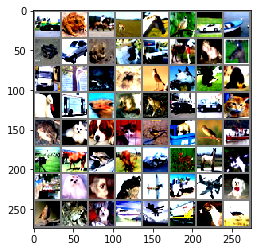

In [8]:
####################################################################################################
## TO DO! : write code to load a batch of images and visualize them                               ##                            ##
####################################################################################################
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


---
__Step-2:__ Define a simple convolutional Neural network with two convolutional layers and 2 fully-connected layers


  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)) \
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) \
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)) \
  (fc1): Linear(in_features=400, out_features=120, bias=True) \
  (fc2): Linear(in_features=120, out_features=84, bias=True) \
  (fc3): Linear(in_features=84, out_features=10, bias=True)


In [9]:
####################################################################################################
## TO DO! : Define Forward pass of the network                                                    ##
####################################################################################################
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



__Step-3:__ Defining the loss function 

In [10]:
criterion = nn.CrossEntropyLoss()

__Step 4:__ Train the network, for 10 epochs and calculate the accuracy on the validation set

Define some utility functions and then functions to train the model on the test set and validate it on the validation set

In [11]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [12]:
####################################################################################################
## DO NOT CHANGE THE CODE HERE!!                                                                  ##
####################################################################################################

def get_accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the 
    k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [13]:
####################################################################################################
## DO NOT CHANGE THE CODE HERE!!                                                                  ##
####################################################################################################
def validate(net, valoader, criterion):
    val_loss = 0
    val_accuracy = 0
    net.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            accuracy = get_accuracy(outputs, targets)
            val_accuracy += accuracy[0].item()
        avg_loss = val_loss/(batch_idx+1)
        avg_acc = val_accuracy/(batch_idx+1)
        
    return avg_loss, avg_acc

In [14]:
####################################################################################################
## DO NOT CHANGE THE CODE HERE!!                                                                  ##
####################################################################################################
def train_one_epoch(model, trainloader, optimizer, criterion):
    model.train()
    train_loss = 0
    train_accuracy = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy = get_accuracy(outputs, targets)
        train_accuracy += accuracy[0].item()
    avg_train_loss = train_loss/(batch_idx+1)
    avg_train_acc = train_accuracy/(batch_idx+1)
    return avg_train_loss, avg_train_acc, model 

In [15]:
####################################################################################################
## TO DO! : Define optimizer (SGD, learning rate = 0.01 and momentum 0.9)                         ##
## TO DO! : Train the model for 10 epochs                                                         ##
####################################################################################################
import torch.optim as optim
model = Net().to(device)
model.apply(weight_reset)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
for epoch in range(10):
    train_loss, train_acc, model = train_one_epoch(model, trainloader,
                                                 optimizer, criterion)
    val_loss, val_acc = validate(model, valloader, criterion)
    message = (f"epoch:{epoch+1}   train_acc:{train_acc:.2f}   "
              f"val_acc:{val_acc:.2f}")
    print(message)

epoch:1   train_acc:17.51   val_acc:27.85
epoch:2   train_acc:35.01   val_acc:39.22
epoch:3   train_acc:41.21   val_acc:40.43
epoch:4   train_acc:44.85   val_acc:41.86
epoch:5   train_acc:47.97   val_acc:46.39
epoch:6   train_acc:50.46   val_acc:47.64
epoch:7   train_acc:52.98   val_acc:51.39
epoch:8   train_acc:54.79   val_acc:53.73
epoch:9   train_acc:56.99   val_acc:54.04
epoch:10   train_acc:58.76   val_acc:55.98


#### Task: Define your own network, such that the validation acccuracy of the model is greater than 70%.  Following constraints should be strictly followed:

1. The network should be trained from scratch (randomly initialized weigths), transfer learning is not allowed

Note: Call __weight_init()__ method over your model before training to make sure model is randomly initialized
2. Use the training methods as defined above (train_one_epoch() and validate() should be used and not changed)
3. Your network should reach atleast 70% accuracy on validatin set under 10 epochs

In [16]:
####################################################################################################
## TO DO! :  Write the implementation of the model here according to the task defined above       ##
## Define any other changes you in optimizer or transforms (if required) in this cell only        ##
## Train the model for 10 epochs and print validation accuracy after the 10th epoch               ##
####################################################################################################

__Hint:__ One might try following ways to obtain the required results:

1) __Filter Size:__ The filter size can be decreased from 5 to 3, this can increase efficiency and reduce overfitting

2) __Number of Filters:__ Increase the number of filters in each convoltuional layer. More convolutional filters gives a network higher representation power

3) __Add more convolutions:__ Increase from two to three convolutional layers. This indeed helps in better receptive fields of the filters and increase represtation power of the network.

4) __Apply Batch Normalizations:__ Batch Normalization will help your model to train faster. Hence it can help the network to converge to better accuracy in less number of epochs

5) __Global Average Pooling:__ Get rid of all the layers and replace them by average pooling and a linear layer for classification. This idea is from the Inception network.  

6) __Regularization:__ Apply L2 regularization and dropout, if you see validation accuracy going much lower than the training accuracy

7) __Different Optimizer:__ Instead of SGD, optimizers like Adam and Adagrad can be tried 

In [17]:
import torch.nn as nn
import torch.nn.functional as F


class Ghost_model(nn.Module):
    def __init__(self):
        super(Ghost_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(12, 32, 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        #print(x.shape)
        x = x.view(-1, 64 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [19]:
import torch.optim as optim
model = Ghost_model().to(device)
model.apply(weight_reset)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
for epoch in range(10):
    train_loss, train_acc, model = train_one_epoch(model, trainloader,
                                                 optimizer, criterion)
    val_loss, val_acc = validate(model, valloader, criterion)
    message = (f"epoch:{epoch+1}   train_acc:{train_acc:.2f}   "
              f"val_acc:{val_acc:.2f}")
    print(message)

epoch:1   train_acc:46.53   val_acc:57.25
epoch:2   train_acc:61.45   val_acc:62.52
epoch:3   train_acc:66.43   val_acc:66.17
epoch:4   train_acc:69.46   val_acc:63.87
epoch:5   train_acc:71.85   val_acc:67.83
epoch:6   train_acc:73.69   val_acc:70.80
epoch:7   train_acc:75.19   val_acc:72.07
epoch:8   train_acc:76.70   val_acc:73.07
epoch:9   train_acc:78.33   val_acc:73.98
epoch:10   train_acc:79.77   val_acc:72.89
